In [1]:
# data manipulation
from jetstream.bigquery_client import BigQueryClient
import numpy as np
import pandas as pd
# visualization
import seaborn as sns
import matplotlib.pyplot as plt
#stats
from statsmodels.stats.proportion import proportion_confint
from sklearn.neighbors import KernelDensity
from scipy.stats import binom, norm, kstest
#misc
from tqdm import tqdm
import pickle as pkl

In [2]:
cache_path = 'simulation_dfs_3.pkl'

In [3]:
def sign(a):
    return (a > 0) - (a < 0)

In [4]:
def CI_to_Pvalue(point: float, lower: float, upper: float, point_null: float = 0.0) -> float:
    '''
    Converts a confidence interval for difference into a 2-sided p-value, 
    assuming large sample normal approximation for the CI
    '''
    if np.isclose(upper, lower):
        return np.nan
    standard_error = (upper - lower)/(2*1.96)
    z_score = (np.abs(point) - point_null)/standard_error
    return (1-norm.cdf(z_score))*2

In [5]:
USE_CACHE = True

In [6]:
if not USE_CACHE:
    dfs = dict()
    for simulation_iteration in tqdm(range(100)): 
        dataset = 'dberry_simulated_AA_tests_{:02d}'.format(simulation_iteration)
        client = BigQueryClient(project='moz-fx-data-experiments',dataset=dataset)
        try:
            overall_results_df = client.table_to_dataframe('statistics_more_from_mozilla_96_overall_1')
        except Exception:
            print(f'Table statistics_more_from_mozilla_96_overall_1 not found!')
            continue
            
        try:
            last_day_results_df = client.table_to_dataframe('statistics_more_from_mozilla_96_day_29')
        except Exception:
            print(f'Table statistics_more_from_mozilla_96_day_29 not found!')
            continue            
            
        sim_results_df = pd.concat([overall_results_df, last_day_results_df])
            
        if sim_results_df.shape[0] == 0:
            print(f'Simulation {simulation_iteration} empty!')
            continue
        comparisons_df = sim_results_df.loc[~sim_results_df.comparison.isnull()].copy()
        comparisons_df.loc[:, 'different_signs'] = (comparisons_df.lower.apply(sign) != comparisons_df.upper.apply(sign))
        comparisons_df.loc[:, 'both_zero'] = np.isclose(comparisons_df.lower.apply(sign) & comparisons_df.upper.apply(sign), 0)
        comparisons_df.loc[:, 'CI_contains_zero'] = comparisons_df[['different_signs', 'both_zero']].apply(
            lambda row: 'Yes' if row.different_signs else ('Both-zero' if row.both_zero else 'No'), 
            axis = 'columns'
        )
    
        dfs[simulation_iteration] = comparisons_df

    with open(cache_path, 'wb') as f:
        pkl.dump(dfs, f)
else:
    with open(cache_path, 'rb') as f:
        dfs = pkl.load(f)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [11:35<00:00,  6.96s/it]


In [7]:
with open(cache_path, 'rb') as f:
    df2s = pkl.load(f)

In [8]:
slug_cols = ['metric', 'statistic', 'parameter', 'branch', 'comparison', 'comparison_to_branch']

In [9]:
for i, df in dfs.items():
    df.loc[:, 'sim_number'] = i
    df.loc[:, 'result_slug'] = df.apply(lambda row: ':'.join(map(str, row[slug_cols])), axis = 'columns')
    df.loc[:, 'p-value'] = df.apply(lambda row: CI_to_Pvalue(row['point'], row['lower'], row['upper']), axis = 'columns')

# Analysis of p-value distributions

In [10]:
aggregate_df = pd.concat([df[[*slug_cols, 'result_slug', 'sim_number', 'p-value']] for df in dfs.values()])

In [11]:
results_pivot = aggregate_df.pivot(index=[*slug_cols, 'result_slug'], columns='sim_number')
sim_cols = ['sim_{:02d}'.format(i) for i in results_pivot.columns.droplevel(0)]
results_pivot.columns = sim_cols
results_pivot = results_pivot.reset_index()

In [12]:
results_no_NAs = results_pivot.loc[results_pivot[sim_cols].isna().mean(axis=1) == 0].copy()
results_NAs = results_pivot.loc[results_pivot[sim_cols].isna().mean(axis=1) != 0].copy()

In [13]:
results_no_NAs.loc[:, 'ks_test_pvalue'] = results_no_NAs.apply(lambda row: kstest(list(row[sim_cols]), 'uniform').pvalue, axis = 'columns')

# Aggregate Results

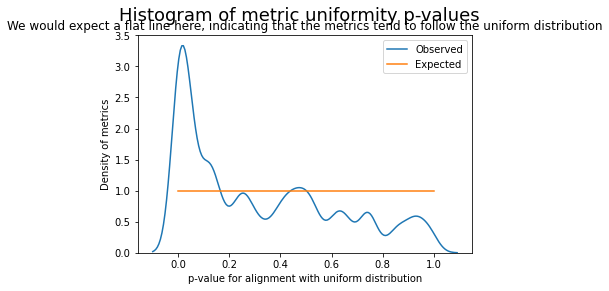

In [14]:
sns.kdeplot(results_no_NAs.ks_test_pvalue, bw_adjust=0.3, label = 'Observed')
sns.lineplot(x=[0,1],y=[1,1], label='Expected')
plt.xlabel('p-value for alignment with uniform distribution')
plt.ylabel('Density of metrics')
plt.suptitle('Histogram of metric uniformity p-values', fontsize=18)
plt.title('We would expect a flat line here, indicating that the metrics tend to follow the uniform distribution')
plt.show()

In [15]:
# Test for all metrics following uniform distribution is rejected, more metrics are rejected than expected

In [16]:
kstest(list(results_no_NAs.ks_test_pvalue), 'uniform')

KstestResult(statistic=0.29489646449646567, pvalue=1.9215187694543463e-13)

In [17]:
(
    results_no_NAs
    .loc[results_no_NAs.ks_test_pvalue < 0.05]
    .sort_values('ks_test_pvalue')
    .drop(columns = sim_cols)
    .to_csv('metric_kstest_pvalues.csv', index = False)
)

In [18]:
# would expect this to be .95 if everything calibrated properly
(results_no_NAs.ks_test_pvalue > 0.05).mean()

0.7261904761904762

## Ten metrics most significantly non-uniform

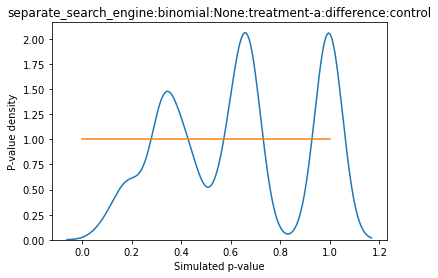

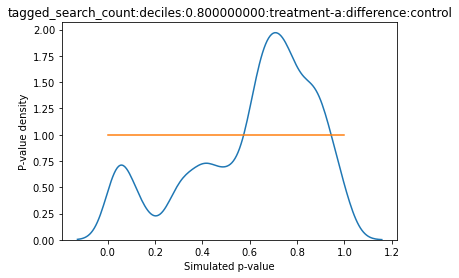

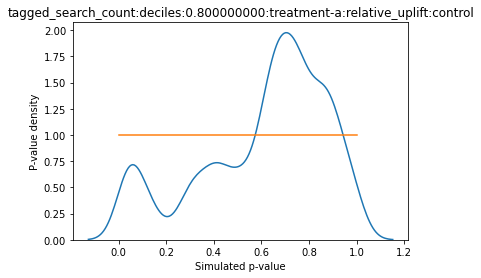

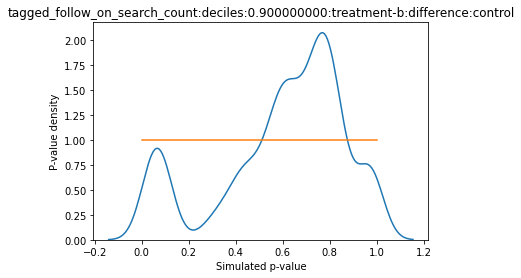

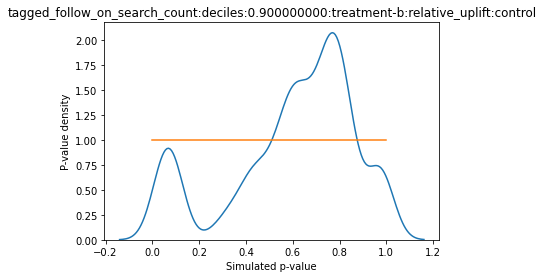

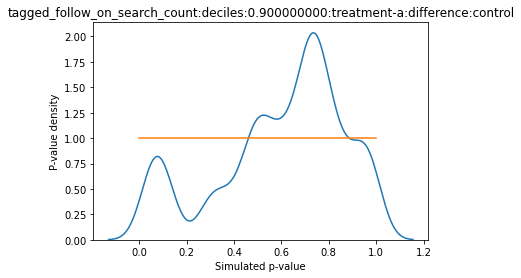

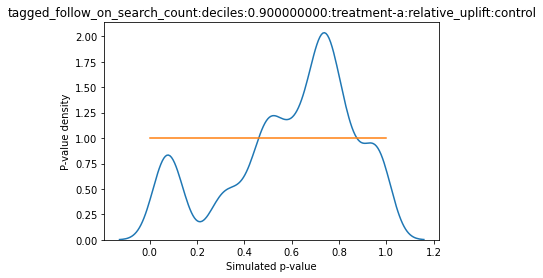

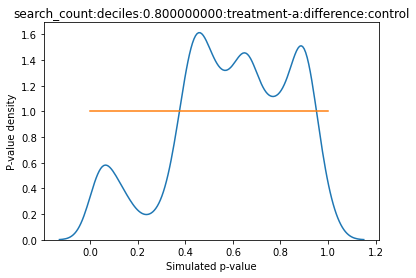

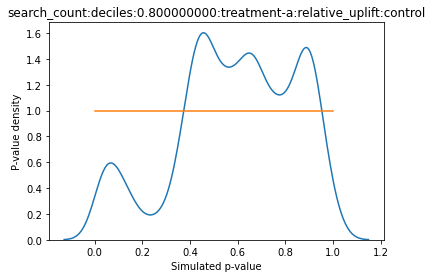

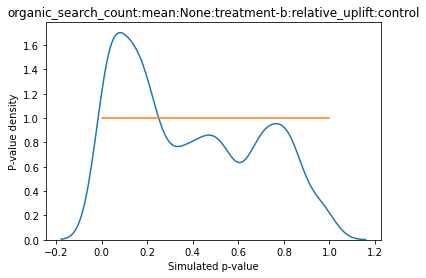

In [19]:
for _, row in results_no_NAs.sort_values('ks_test_pvalue').head(10).iterrows():
    sns.kdeplot(row[sim_cols], bw_adjust=0.5)
    sns.lineplot(x=[0,1],y=[1,1])
    plt.title(row['result_slug'])
    plt.xlabel('Simulated p-value')
    plt.ylabel('P-value density')
    plt.show()

In [20]:
results_pivot.metric.value_counts()

active_hours                     40
ad_clicks                        40
days_of_use                      40
organic_search_count             40
search_count                     40
searches_with_ads                40
tagged_follow_on_search_count    40
tagged_search_count              40
uri_count                        40
retained                          4
separate_search_engine            4
unenroll                          4
Name: metric, dtype: int64

In [21]:
results_NAs.metric.value_counts()

ad_clicks                        36
organic_search_count             32
searches_with_ads                32
days_of_use                      28
tagged_follow_on_search_count    28
search_count                     24
tagged_search_count              24
Name: metric, dtype: int64

In [22]:
results_no_NAs.metric.value_counts()

active_hours                     40
uri_count                        40
search_count                     16
tagged_search_count              16
days_of_use                      12
tagged_follow_on_search_count    12
organic_search_count              8
searches_with_ads                 8
ad_clicks                         4
retained                          4
separate_search_engine            4
unenroll                          4
Name: metric, dtype: int64

In [23]:
def plot_pvalue_distribution_for_metric(metric: str, statistic: str, branch: str, comparison: str, bw_adjust=0.3) -> None:
    row = results_no_NAs.loc[(
        (results_no_NAs.metric == metric) &
        (results_no_NAs.statistic == statistic) &
        (results_no_NAs.branch == branch) &
        (results_no_NAs.comparison == comparison)
    )].iloc[0]
    print('KS test for follows uniform distribution p-value: {:0.4f}'.format(row.ks_test_pvalue))
    sns.kdeplot(row[sim_cols], bw_adjust=bw_adjust, label='Actual')
    sns.lineplot(x=[0,1],y=[1,1], label='Expected')
    plt.title(row['result_slug'])
    plt.xlabel('Simulated p-value')
    plt.ylabel('P-value density')
    plt.show()
    

## Retention

KS test for follows uniform distribution p-value: 0.6641


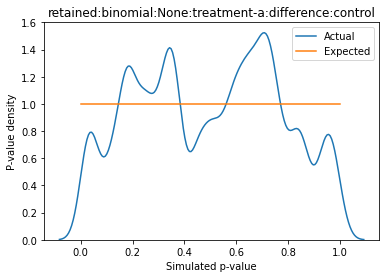

In [24]:
plot_pvalue_distribution_for_metric('retained', 'binomial', 'treatment-a', 'difference')

KS test for follows uniform distribution p-value: 0.6068


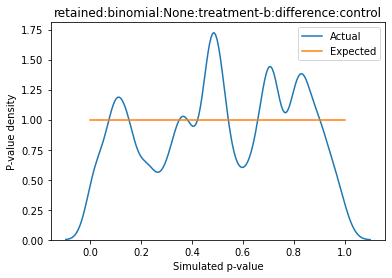

In [25]:
plot_pvalue_distribution_for_metric('retained', 'binomial', 'treatment-b', 'difference')

## Active Hours

KS test for follows uniform distribution p-value: 0.0289


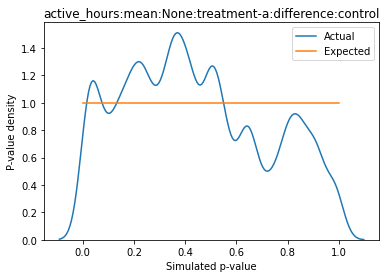

In [26]:
plot_pvalue_distribution_for_metric('active_hours', 'mean', 'treatment-a', 'difference')

KS test for follows uniform distribution p-value: 0.6369


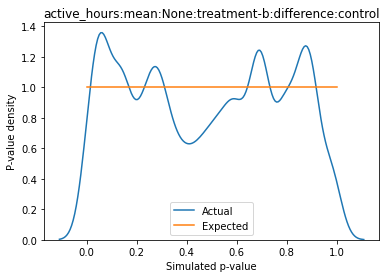

In [27]:
plot_pvalue_distribution_for_metric('active_hours', 'mean', 'treatment-b', 'difference')

## Days of Use

KS test for follows uniform distribution p-value: 0.9270


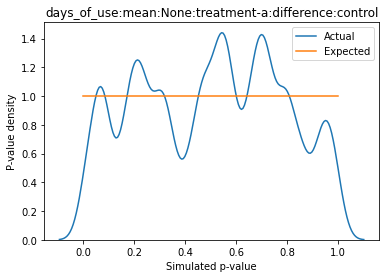

In [28]:
plot_pvalue_distribution_for_metric('days_of_use', 'mean', 'treatment-a', 'difference')

KS test for follows uniform distribution p-value: 0.5254


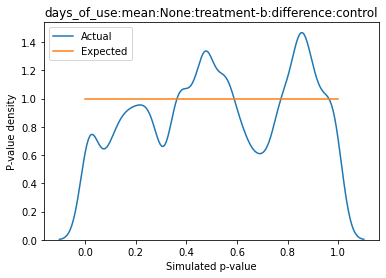

In [29]:
plot_pvalue_distribution_for_metric('days_of_use', 'mean', 'treatment-b', 'difference')

## URI Count

KS test for follows uniform distribution p-value: 0.3637


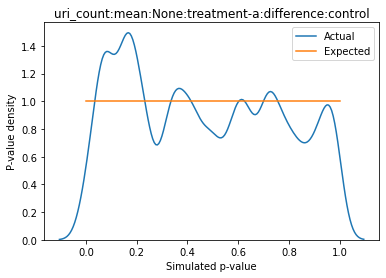

In [30]:
plot_pvalue_distribution_for_metric('uri_count', 'mean', 'treatment-a', 'difference')

KS test for follows uniform distribution p-value: 0.2750


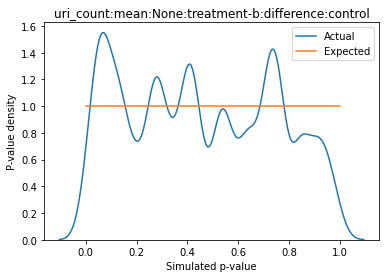

In [31]:
plot_pvalue_distribution_for_metric('uri_count', 'mean', 'treatment-b', 'difference')

## Search Count

KS test for follows uniform distribution p-value: 0.8622


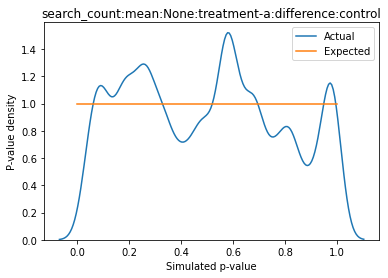

In [32]:
plot_pvalue_distribution_for_metric('search_count', 'mean', 'treatment-a', 'difference')

KS test for follows uniform distribution p-value: 0.2890


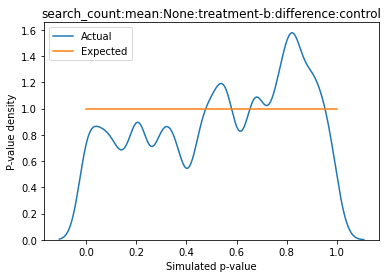

In [33]:
plot_pvalue_distribution_for_metric('search_count', 'mean', 'treatment-b', 'difference')

## Tagged Search Count

KS test for follows uniform distribution p-value: 0.9921


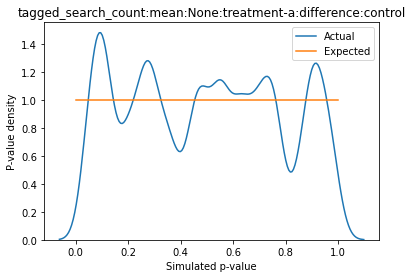

In [34]:
plot_pvalue_distribution_for_metric('tagged_search_count', 'mean', 'treatment-a', 'difference')

KS test for follows uniform distribution p-value: 0.1242


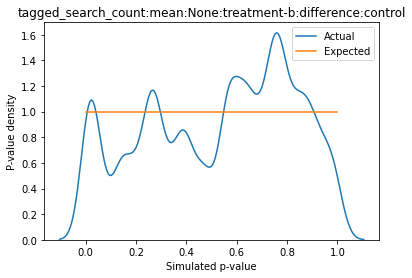

In [35]:
plot_pvalue_distribution_for_metric('tagged_search_count', 'mean', 'treatment-b', 'difference')

## Tagged Follow On Search Count

KS test for follows uniform distribution p-value: 0.1431


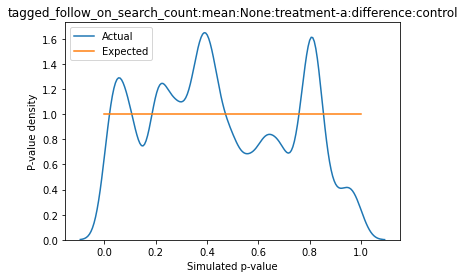

In [36]:
plot_pvalue_distribution_for_metric('tagged_follow_on_search_count', 'mean', 'treatment-a', 'difference')

KS test for follows uniform distribution p-value: 0.9364


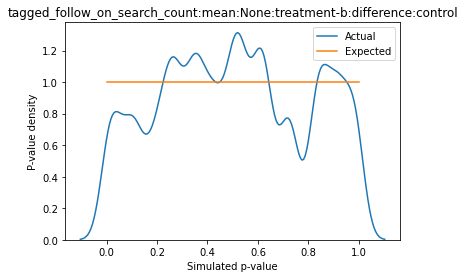

In [37]:
plot_pvalue_distribution_for_metric('tagged_follow_on_search_count', 'mean', 'treatment-b', 'difference')

## Organic Search Count

KS test for follows uniform distribution p-value: 0.0099


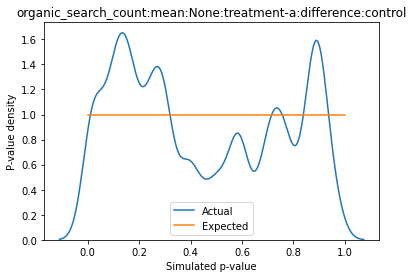

In [38]:
plot_pvalue_distribution_for_metric('organic_search_count', 'mean', 'treatment-a', 'difference')

KS test for follows uniform distribution p-value: 0.0002


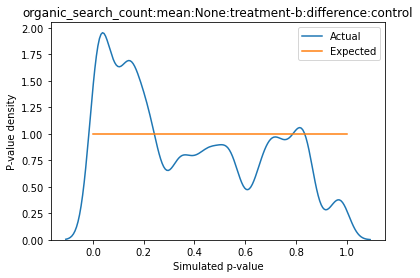

In [39]:
plot_pvalue_distribution_for_metric('organic_search_count', 'mean', 'treatment-b', 'difference')

## Searches With Ads

KS test for follows uniform distribution p-value: 0.4546


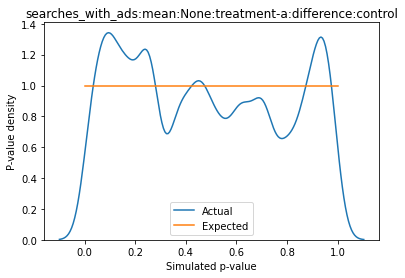

In [40]:
plot_pvalue_distribution_for_metric('searches_with_ads', 'mean', 'treatment-a', 'difference')

KS test for follows uniform distribution p-value: 0.0073


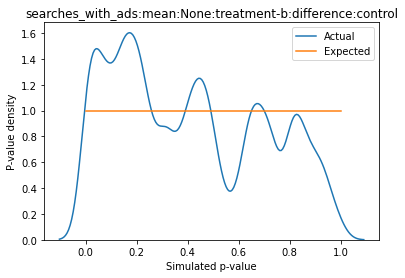

In [41]:
plot_pvalue_distribution_for_metric('searches_with_ads', 'mean', 'treatment-b', 'difference')

## Ad Clicks

KS test for follows uniform distribution p-value: 0.1757


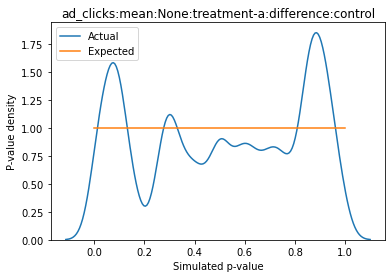

In [42]:
plot_pvalue_distribution_for_metric('ad_clicks', 'mean', 'treatment-a', 'difference')

KS test for follows uniform distribution p-value: 0.1541


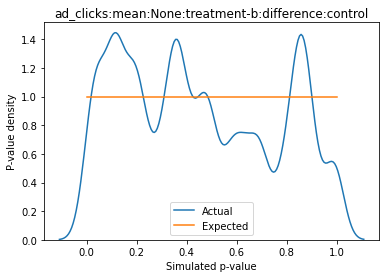

In [43]:
plot_pvalue_distribution_for_metric('ad_clicks', 'mean', 'treatment-b', 'difference')

## Separate Search Engine

KS test for follows uniform distribution p-value: 0.0000


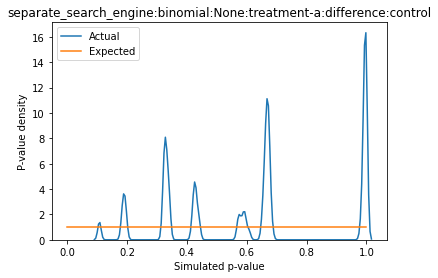

In [44]:
plot_pvalue_distribution_for_metric('separate_search_engine', 'binomial', 'treatment-a', 'difference', bw_adjust=0.05)

KS test for follows uniform distribution p-value: 0.0003


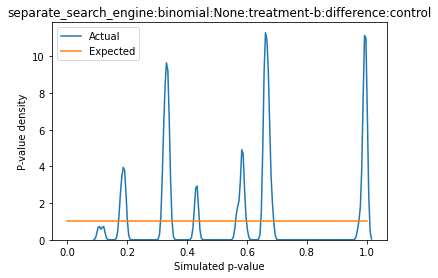

In [45]:
plot_pvalue_distribution_for_metric('separate_search_engine', 'binomial', 'treatment-b', 'difference', bw_adjust=0.05)

## Test core metrics for distributional accuracy

In [46]:
core_metrics = pd.DataFrame([
    ('retained', 'binomial'),
    ('active_hours', 'mean'),
    ('days_of_use', 'mean'),
    ('uri_count', 'mean'),
    ('search_count', 'mean'),
    ('tagged_search_count', 'mean'),
    ('tagged_follow_on_search_count', 'mean'),
    ('organic_search_count','mean'),
    ('searches_with_ads', 'mean'),
    ('ad_clicks', 'mean'),
    ('separate_search_engine', 'binomial')
], columns = ['metric', 'statistic'])

In [47]:
core_pvals = results_no_NAs.merge(core_metrics, on=['metric', 'statistic']).query('comparison=="difference"').ks_test_pvalue

In [48]:
from statsmodels.stats.multitest import multipletests

In [49]:
reject, core_pvals_corrected, alphacSidak, alphacBonf = multipletests(core_pvals, method='holm')

In [50]:
reject.sum()

3

In [51]:
results_no_NAs.merge(core_metrics, on=['metric', 'statistic']).query('comparison=="difference"')[reject]

,metric,statistic,parameter,branch,comparison,comparison_to_branch,result_slug,sim_00,sim_01,sim_02,...,sim_91,sim_92,sim_93,sim_94,sim_95,sim_96,sim_97,sim_98,sim_99,ks_test_pvalue
14,organic_search_count,mean,NaN,treatment-b,difference,control,organic_search_count:mean:None:treatment-b:dif...,0.008817,0.515477,0.664396,...,0.118970,0.046538,0.721574,0.451145,0.158128,0.081804,0.924427,0.434339,0.984876,2.374552e-04
28,separate_search_engine,binomial,NaN,treatment-a,difference,control,separate_search_engine:binomial:None:treatment...,0.662330,0.670320,0.660272,...,0.329518,0.431695,0.671145,0.321659,0.425944,0.570378,0.981548,0.662279,0.428001,5.264975e-07
30,separate_search_engine,binomial,NaN,treatment-b,difference,control,separate_search_engine:binomial:None:treatment...,0.663815,0.991690,0.991754,...,0.324832,0.565154,0.670021,0.333470,0.179391,0.433566,0.661831,0.991117,0.192470,2.632039e-04


In [52]:
kstest(core_pvals, 'uniform')

KstestResult(statistic=0.2788653497804818, pvalue=0.05267151039042994)

# Methodology Validation

In [53]:
from scipy.stats import uniform
from joblib import Parallel, delayed

In [54]:
def run_sim(i):
    simulated_simulation_pvalues = pd.DataFrame(uniform.rvs(size=(100,100), random_state = i), columns = range(100))
    pvals = simulated_simulation_pvalues.apply(lambda row: kstest(list(row), 'uniform').pvalue, axis = 'columns')
    return kstest(pvals, 'uniform').pvalue

In [55]:
%%time
validation_pvals = Parallel(n_jobs=8)(delayed(run_sim)(i) for i in range(10000))

CPU times: user 27.1 s, sys: 2.02 s, total: 29.1 s
Wall time: 3min 49s


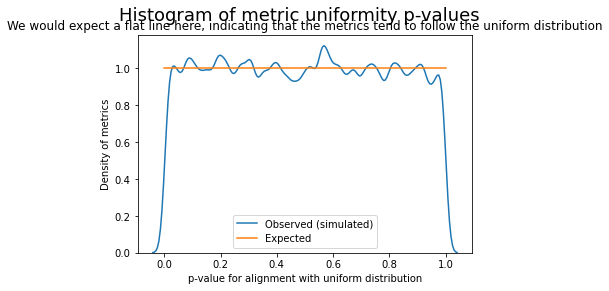

In [56]:
sns.kdeplot(validation_pvals, bw_adjust=0.3, label = 'Observed (simulated)')
sns.lineplot(x=[0,1],y=[1,1], label='Expected')
plt.xlabel('p-value for alignment with uniform distribution')
plt.ylabel('Density of metrics')
plt.suptitle('Histogram of metric uniformity p-values', fontsize=18)
plt.title('We would expect a flat line here, indicating that the metrics tend to follow the uniform distribution')
plt.show()

In [57]:
kstest(validation_pvals, 'uniform')

KstestResult(statistic=0.005782178298437357, pvalue=0.8897581552170855)

# Analysis using CI contains-zero methodology

In [58]:
return ValueError('Work in progress')

SyntaxError: 'return' outside function (2880021171.py, line 1)

In [ ]:
aggregate_df = pd.concat([df[['result_slug', 'sim_number', 'CI_contains_zero']] for df in dfs.values()])

In [ ]:
results_pivot = aggregate_df.pivot(index='sim_number', columns='result_slug')

In [ ]:
results_pivot.columns = results_pivot.columns.droplevel(0)

In [ ]:
prop_sims_with_zero_width_CIs = results_pivot.apply(lambda col: (col == 'Both-zero').mean())

In [ ]:
prop_sims_with_zero_width_CIs[prop_sims_with_zero_width_CIs > 0]

In [ ]:
results_positive_width = results_pivot[prop_sims_with_zero_width_CIs[prop_sims_with_zero_width_CIs == 0].index]

In [ ]:
success_rates = (results_positive_width == 'Yes').mean()
sns.distplot(success_rates)

In [ ]:
kde = KernelDensity(kernel="gaussian", bandwidth=0.01).fit(np.asarray(success_rates).reshape(-1, 1))
X_plot = np.linspace(.75, 1.05, 1000).reshape(-1,1)
dens = np.exp(kde.score_samples(X_plot))

In [ ]:
n_metrics = len(results_positive_width.columns)
null_metric_success_probability = 0.95

In [ ]:
ax = plt.subplots(figsize = (20,10))
sns.lineplot(x=X_plot[:,0], y=dens/dens.sum(), label='Observed')
sns.lineplot(x=np.arange(0,1+1/n_metrics,1/n_metrics), 
             y = binom.pmf(range(n_metrics+1), n_metrics, null_metric_success_probability) * 1/n_metrics, label = 'Theoretical')
plt.xlim((0.7,1.0))
plt.show()